# Frauenhofer diffraction and Fourier filtering

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [14, 10]

# Functions to make it easy to draw patterns on the aperture.

In [138]:
#c = 3e8 # m/s

def inboxA(screen,center,fullwidth):
    # screen must be 2D square numpy array.
    # center must be a tuple, (xcenter,ycenter)
    n_elements = screen.shape[0]
    middle = center[0]
    xmin = middle - fullwidth/2
    xmax = middle + fullwidth/2
    ymin = middle - fullwidth/2
    ymax = middle + fullwidth/2
    for x in range(n_elements):
        for y in range(n_elements):
            if ( (x>xmin) and (x<xmax) and (y>ymin) and (y<ymax)):
                val = 1
            else:
                val = 0
            screen[x,y] = val
    return screen

def incircleA(screen,center,radius):
    # screen must be 2D square numpy array.
    # center must be a tuple, (xcenter,ycenter)
    n_elements = screen.shape[0]
    x0 = center[0]
    y0 = center[1]
    for x in range(n_elements):
        for y in range(n_elements):
            rpix = np.sqrt( (x-x0)**2 + (y-y0)**2)
            if ( rpix < radius):
                val = 1
            else:
                val = 0
            screen[x,y] = val
    return screen

def gaussian(screen, center, sigma):
    # screen must be 2D square numpy array.
    # center must be a tuple, (xcenter,ycenter)
    x0 = center[0]
    y0 = center[1]
    n_elements = screen.shape[0]
    for x in range(n_elements):
        for y in range(n_elements):
            rpix = np.sqrt( (x-x0)**2 + (y-y0)**2)
            val = np.exp(-(rpix**2)/(2*sigma**2))
            screen[x,y] = val
    return screen


def xslit(screen,xval,width):
    n_elements = screen.shape[0]
    for x in range(n_elements):
        for y in range(n_elements):
            if np.abs(x-xval)<width:
                val = 1
            else:
                val =0
            screen[x,y] = val
    return screen

def doubleslit(x,y):
    x0 = 64 - 10
    x1 = 64 + 10
    width = 3
    if (np.abs(x0-x)<width) or (np.abs(x1-x)<width):
        val = 1
    else:
        val =0
    return val

def slitgrid():
    gridsize = 512
    mygrid=np.zeros((gridsize,gridsize))
    x0 = np.arange(0,gridsize,int(gridsize/20.))
    y0 = x0
    mygrid[x0,:] = 1
    mygrid[x0+1,:] = 1
    mygrid[:,y0] = 1
    mygrid[:,y0+1] = 1
    return mygrid

# Set up the size and resolution fo the aperture, the wavelength, etc.

In [139]:
# Now set up the aperture
N = 1000   # resolution elements across the aperture
x0 = N/2. # center of opening
y0 = x0
screen = np.zeros((N,N))

# Set up details of system
D_ap = 0.01  # meters, size of the aperture screen 
xmax = D_ap/2.
lam = 0.002   # meters, wavelength of light
k = 2*np.pi/lam  # k-vector of incident light
dk = 1/D_ap    # transverse k_vector bin width

# We need to find the maximum value of k_x and k_y allowed.
# We will do the FFT, then discard values of higher k_x, k_y than this
# Or maybe higher k_transverse than this.
theta_max = np.pi/2.
k_xmax = k*np.sin(theta_max)  # same as k_ymax

# Choose an aperture E-field distribution.

In [149]:
#screen = inboxA(screen,(x0,y0),N/40)

screen = incircleA(screen,(x0,y0),N/100.) + np.random.normal(scale=0.1,size=(N,N))

#sigma_elements = N/40.
#screen = gaussian(screen, (x0,y0),sigma_elements)

#screen = slitgrid()
#screen = xslit(screen,N/2,10)

# Take the Fourier transform of the aperture

In [150]:
# Fourier transform gives kx,ky vector amplitudes, corresponding to thetas above.
#
E_beam = np.fft.fftshift(np.fft.fft2(screen))

# Plot the aperture field, and the fourier plane E-field

Text(0.5, 1.0, 'k-plane')

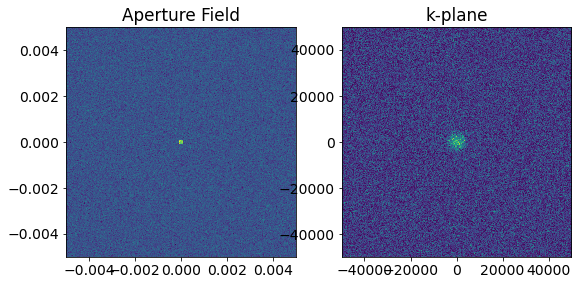

In [151]:
plt.clf()
#
plt.subplot(231)
plt.imshow(screen,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Aperture Field')
#
kmax = np.max(kvec)
plt.subplot(232)
plt.imshow(np.abs(E_beam),origin='lower',interpolation='none',extent=[-kmax,kmax,-kmax,kmax])
plt.title('k-plane')

# Create a Fourier Filter

In [153]:
n_elements = screen.shape[0]
kvec = dk*np.fft.fftfreq(n_elements)*n_elements # renormalize fftfreq grid 
#
# Generate 2D array of kx and ky values for each point in the k_plane
kx_array = np.fft.fftshift(np.tile(kvec,(kvec.size,1)))
ky_array = kx_array.transpose()
filter_t = 0*kx_array
filter_t = incircleA(filter_t,(x0,y0),N/20)


E_beam_f = E_beam*filter_t
transform_image = np.fft.ifft2(np.fft.fftshift(E_beam_f))

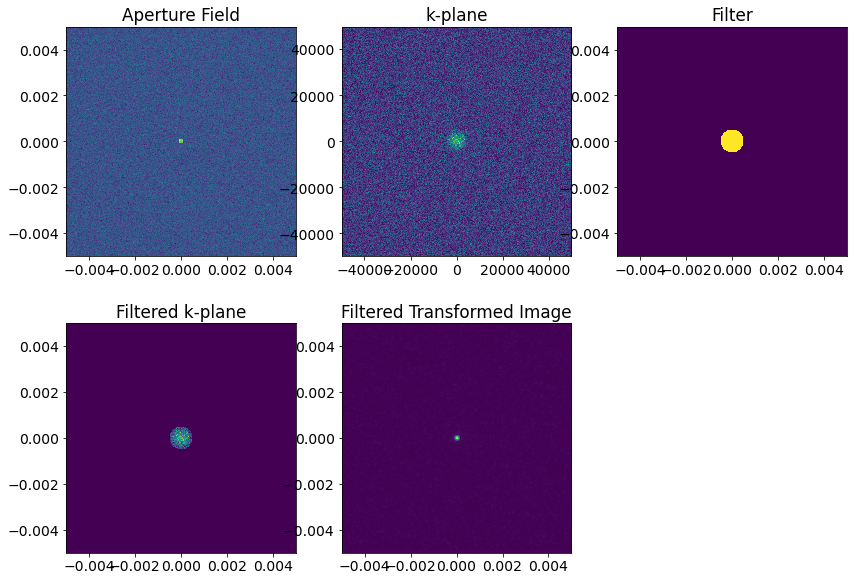

In [154]:
# plotting

plt.figure(1)
plt.clf()
#
plt.subplot(231)
plt.imshow(screen,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Aperture Field')
#
kmax = np.max(kvec)
plt.subplot(232)
plt.imshow(np.abs(E_beam),origin='lower',interpolation='none',extent=[-kmax,kmax,-kmax,kmax])
plt.title('k-plane')
#
plt.subplot(233)
plt.imshow(filter_t,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Filter')
#
plt.subplot(234)
plt.imshow(np.abs(E_beam_f),origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Filtered k-plane')
#
plt.subplot(235)
plt.imshow(np.abs(transform_image),origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Filtered Transformed Image')

plt.show()


# Gaussian

500.0
500.0
1000


(1000, 1000)

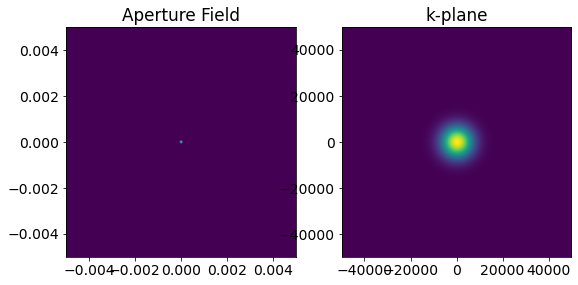

In [136]:
screen = np.zeros((N,N))
sigma_elements = N/300.
x0 = N/2
y0 = x0

screen = gaussian(screen, (x0,y0),sigma_elements)
E_beam = np.fft.fftshift(np.fft.fft2(screen))
plt.clf()
#
plt.subplot(231)
plt.imshow(screen,origin='lower',interpolation='none', extent = [-xmax,xmax,-xmax,xmax])
plt.title('Aperture Field')
#
kmax = np.max(kvec)
plt.subplot(232)
plt.imshow(np.abs(E_beam),origin='lower',interpolation='none',extent=[-kmax,kmax,-kmax,kmax])
plt.title('k-plane')

print(x0)
print(y0)
print(N)
screen.shape